<a href="https://colab.research.google.com/github/daniellmarc/reweighted-dns/blob/main/GW170817_galacticmass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [ ]:
#Pip Install the package called pesummary and corner
! pip install pesummary
import pesummary #Summary pages for all sample generating codes

! pip install corner
import corner #Uses matplotlib to visualize multidimensional samples using a scatterplot matrix


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.lines as mlines
# ! pip install matplotlib==3.1.3 # An error keeps popping up when i had to plot " : cannot import name '_png' from 'matplotlib' ". So I did this


#Install a custom package provided by Phil Laundry git hub repo 

! git clone -b apjl2021 https://github.com/landryp/sodapop.git # only need to run this once
import sys #NOT SURE WHAT SYS IS 
sys.path.insert(0,'/content/sodapop') 
import sodapop.priors as prior #prior information import 
import sodapop.populations as pop #population samples import 


import pesummary
from pesummary.io import read
print(pesummary.__version__)
import numpy as np # linear algebra


import pandas as pd
# pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

import os


# Read and visualize parameter samples from public LVK paper results on GW170817

In [ ]:
public_dcc_url= 'https://dcc.ligo.org/public/0150/P1800061/011/'

In [ ]:
!curl -O {public_dcc_url}"high_spin_PhenomPNRT_posterior_samples.dat.gz"
# !curl -O {public_dcc_url}"low_spin_PhenomPNRT_posterior_samples.dat.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  971k  100  971k    0     0  1212k      0 --:--:-- --:--:-- --:--:-- 1212k


In [ ]:
# reading the high_spin_PhenomPNRT_posterior_samples.dat.gz file into a pandas data frame
data = pd.read_table('high_spin_PhenomPNRT_posterior_samples.dat.gz', delim_whitespace=True)

In [ ]:
# list the labels for the sampled parameters
pnames = data.columns.values #
print('\n\n List of Parameters in public data release:')
print(pnames, '\n')



 List of Parameters in public data release:
['costheta_jn' 'luminosity_distance_Mpc'
 'm1_detector_frame_Msun' 'm2_detector_frame_Msun' 'lambda1'
 'lambda2' 'spin1' 'spin2' 'costilt1' 'costilt2'] 



Calculate source frame masses from redshift factor appropriate to the luminosity distance recovered for the sample

---
neglects peculiar velocity of galaxy and of the object within the galaxy; see GW170817 discovery paper for assesssment of error from this



In [ ]:
# apply local universe cosmology to convert from detector frame masses recorded to source frame
H0 = 67.4 # planck 2018 H0 in km/s/Mpc Used to account of change of masses from the red shift. Use this for GW190425. 
c = 2.998e5 # speed of light in km/s

In [ ]:
data['m1'] = data.apply(lambda row : row['m1_detector_frame_Msun'] / (1+H0 * row['luminosity_distance_Mpc']/c) , axis = 1)
data['m2'] = data.apply(lambda row : row['m2_detector_frame_Msun'] / (1+H0 * row['luminosity_distance_Mpc']/c) , axis = 1)

Define functions that can be used to map from the sampled parameters into other parameters of astrophysical or data science interest 




In [ ]:
def mchirp_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return eta_from_mass1_mass2(mass1, mass2)**(3./5) * (mass1+mass2)
def eta_from_mass1_mass2(mass1, mass2):
    """Returns the symmetric mass ratio from mass1 and mass2."""
    return mass1*mass2 / (mass1+mass2)**2.

def chi_eff(mass1, mass2, spin1z, spin2z): 
    """Returns the effective spin from mass1, mass2, spin1z, and spin2z."""
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)

def lambdatilde(lambda1,lambda2,m1,m2): 
    mtotal = m1+m2
    m1fac=m1+12*m2
    m2fac=m2+12*m1
    return 16./13*(m1fac*m1**(4)*lambda1+m2fac*m2**(4)*lambda2)/mtotal**(5)

Apply the functions to the sample data to generate columns for mchirp, q, chi_eff, and lambdatilde

In [ ]:
data['mchirp'] = data.apply(lambda row : mchirp_from_mass1_mass2(row['m1'], row['m2']) , axis = 1)
data['q']= data.apply(lambda row : row['m2']/ row['m1'] , axis = 1)
# chi_eff needs z-component of spins (along axis of orbit), multiply spin amplitude by cosine of the tilt angle
data['chi_eff']= data.apply(lambda row : chi_eff(
    row['m1'], row['m2'], row['spin1']*row['costilt1'],row['spin2']*row['costilt2']  ) , axis = 1)
data['lambdatilde'] = data.apply(lambda row : lambdatilde(
    row['lambda1'], row['lambda2'], row['m1'], row['m2'] ) , axis = 1)

Visualize a corner plot of the LVK sampling parameter estimation results

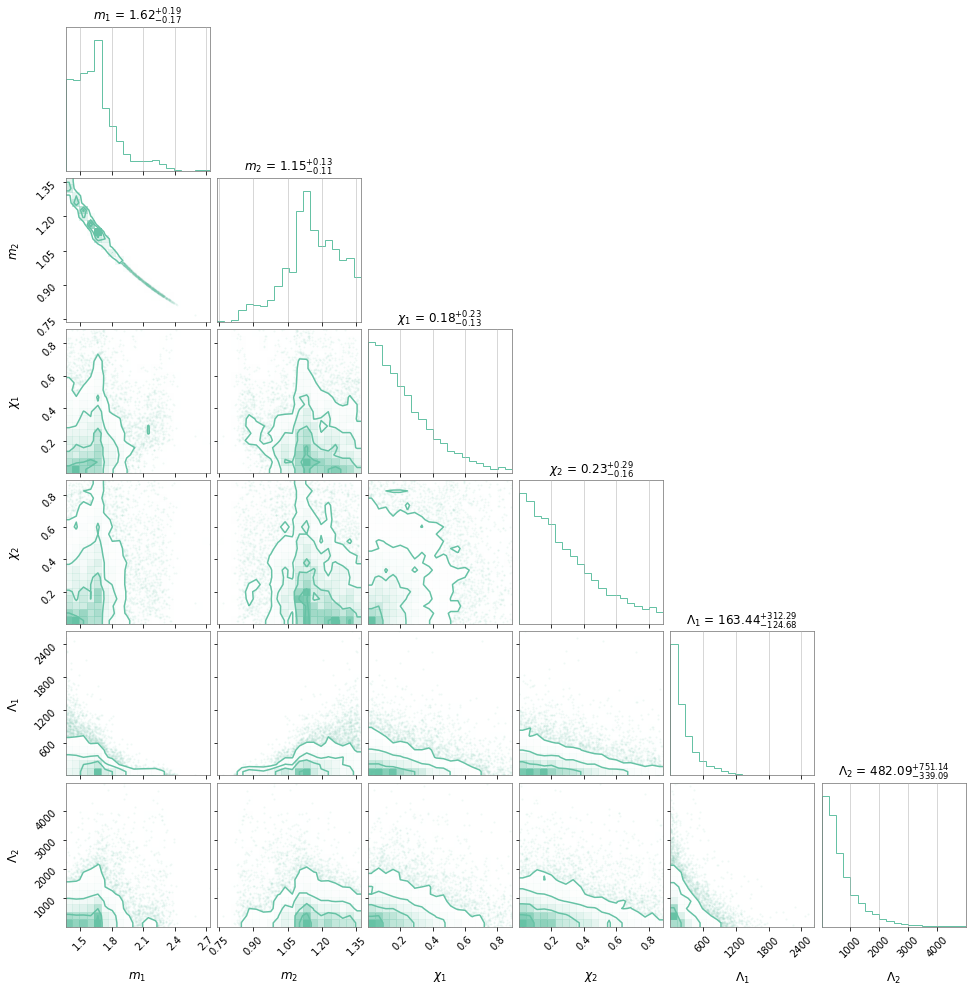

In [ ]:
cmap = plt.cm.get_cmap('Set2', 6) #cmap(0)
figure = corner.corner(data,color = cmap(0),var_names = ["m1", "m2",'spin1','spin2',"lambda1", "lambda2"],
                       labels = (r"$m_1$",r"$m_2$",r"$\chi_1$",r"$\chi_2$",r"$\Lambda_1$",r"$\Lambda_2$"),
                       show_titles=True) 

Remap to show leading-order parameter combinations which are more tightly constrained, using the new columns calculated previously

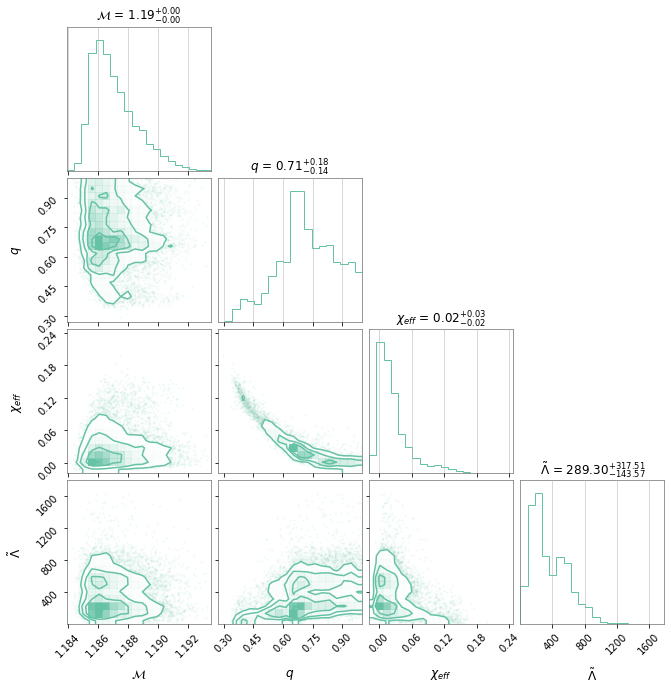

In [ ]:
figure = corner.corner(data,color = cmap(0),var_names = ["mchirp","q",'chi_eff',"lambdatilde"],
                       labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$"),
                       show_titles=True)

# Considering different prior assumptions

First: see results if a galactic mass distribution is assumed to describe GW sources

In [ ]:
old_prior_mass=prior.get_binary_mass_prior('flat_m1m2det') #function of m1, m2, lum_dist
new_prior_mass=pop.get_pop_prior('bimodcut_m1m2_snrcut') # function of m1, m2, lum_dist


# weight samples based on galactic mass prior
data['massweight']  = data.apply(lambda row :
                            new_prior_mass(row['m1'],row['m2'],row['luminosity_distance_Mpc'])  
                            /  old_prior_mass(row['m1'],row['m2'],row['luminosity_distance_Mpc']) 
                            , axis = 1)
# normalize the weights for distribution comparisons
data['massweight']=data['massweight']/data['massweight'].sum() * data['massweight'].size

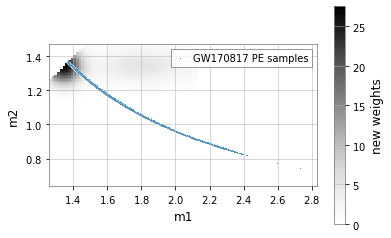

In [ ]:
x_coords = np.linspace(min(data['m1'])-0.1,max(data['m1'])+0.1,100)
y_coords = np.linspace(min(data['m2'])-0.1,max(data['m2'])+0.1,100)
X, Y = np.meshgrid(x_coords, y_coords)
avg_lumdist = data['luminosity_distance_Mpc'].sum() / data['massweight'].size
Z = np.vectorize(new_prior_mass)(X,Y,avg_lumdist)

fig = plt.pcolormesh(x_coords, y_coords, Z, cmap='Greys')
fig.axes.set_aspect('equal')
plt.colorbar(label="new weights")

#plt.xlim(1.3,2.5)
#plt.ylim(0.8,2.0)
sns.scatterplot(data=data, x='m1', y='m2',  marker=",", s=1, label = "GW170817 PE samples")
plt.legend()


Apply the prior reweighting to the distributions

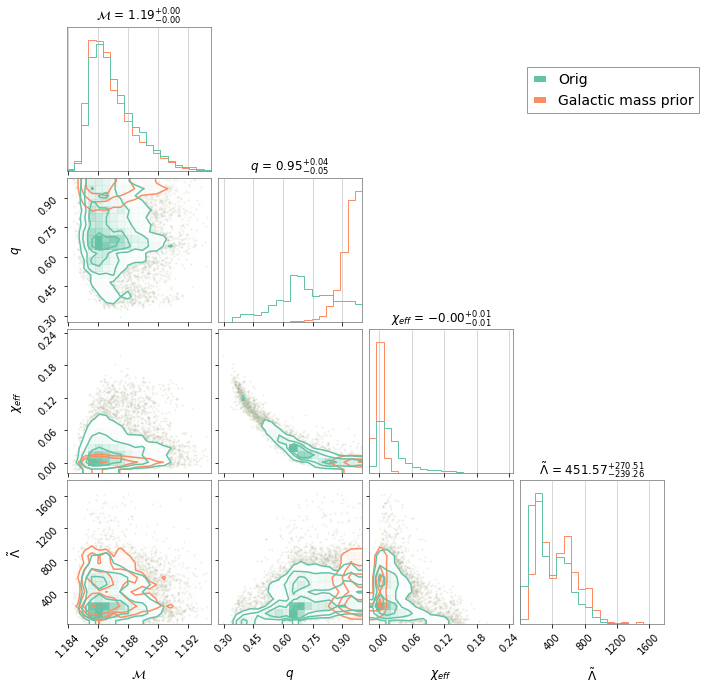

In [ ]:
figure = corner.corner(data,weights = data["massweight"], color = cmap(1),var_names = ["mchirp","q",'chi_eff',"lambdatilde"],
                       labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$"),
                       show_titles=True)
corner.corner(data,color = cmap(0),fig=figure, var_names = ["mchirp","q",'chi_eff',"lambdatilde"],
              labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$"))

l1 = mlines.Line2D([], [], color=cmap(0), label='Orig')
l2 = mlines.Line2D([], [], color=cmap(1), label='Galactic mass prior')
plt.legend(handles=[l1,l2],bbox_to_anchor=(0, 3.5,1,2), loc='lower left',fontsize= 14)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


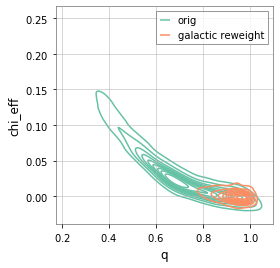

In [ ]:
fig = sns.kdeplot(data=data, x='q', y='chi_eff',  color=cmap(0), label='orig')
sns.kdeplot(data=data, x='q', y='chi_eff',  color=cmap(1), label='galactic reweight',
            weights = data['massweight'])
plt.axes().set_aspect(1./plt.axes().get_data_ratio())
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'aspect'
  **contour_kws,
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'aspect'
  **contour_kws,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


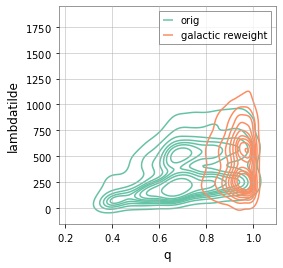

In [ ]:
fig = sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(0), label='orig',aspect=1)
sns.kdeplot(data=data, x='q', y='lambdatilde', color=cmap(1), label='galactic reweight',
            weights = data['massweight'],aspect=1)
plt.axes().set_aspect(1./plt.axes().get_data_ratio())
plt.legend()
plt.show()

In [35]:
#Defined a function to reflect KDEs around hard boundaries 
def reflect(x_reflect, point_reflect):
  diff_reflect = (x_reflect - point_reflect)#Used when the point of reflect is not just 0.
  opp_reflect = point_reflect - diff_reflect #Create the same  values for kde is now in the opposite side of the point of reflect
  return opp_reflect



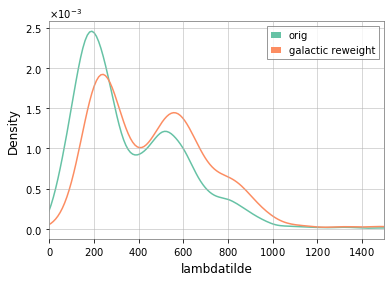

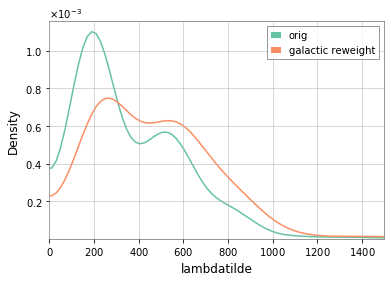

In [42]:
#1-D KDE plot of Lambdatilde, no flat prior. Peak is incorrect due to the hard boundaries set. There are chances of having lambdatilde to be 0 

data_reflect = reflect(data['lambdatilde'], 0)
trueKDE = list(data_reflect) + list(data['lambdatilde']) #

trueKDE_weights = list(data['massweight']) + list(data['massweight']) 

# Originial plots before considering the hard boundaries
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(0), label='orig')
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(1), label='galactic reweight',
            weights = data['massweight'])
plt.xlim(0,1500)
plt.legend()
plt.show()

#New plot that considers the hard boundaries
sns.kdeplot(x= trueKDE,  color=cmap(0), label='orig')
sns.kdeplot(x=trueKDE,  color=cmap(1), label='galactic reweight',
            weights = trueKDE_weights)
plt.xlim(0,1500)
plt.xlabel('lambdatilde')
plt.legend()
plt.show()


alternative prior prescription for lambda

In [ ]:
# since we sample uniformly in components, this is the prior on lambda_tilde
def unif_component_prior(q,z,Lmax1, Lmax2): 
    #Lambda-tilde is called z here for conciseness
    mtotal = 1+q
    m1fac= 1+12*q
    m2fac= q+12
    A = 16./13*(m1fac)/mtotal**(5)
    B = 16./13*(m2fac*q**(4))/mtotal**(5)
    norm = A*B *Lmax1*Lmax2
    return  (np.heaviside(z / A,1.) * ( 
        z + (A * Lmax1 - z) * np.heaviside(z/A - Lmax1,1.) ) - np.heaviside(z/A - B * Lmax2/A, 1.) * ( 
        z - B * Lmax2 + (A * Lmax1 + B * Lmax2 - z) * np.heaviside(z/A - (A * Lmax1 + B * Lmax2) / A,1.)) )/norm

# for GW170817 sampling here
Lmax=5000 # uniform prior maximum lambda for both components

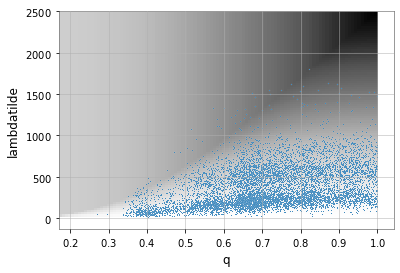

In [ ]:
#Scatter plot that describes the pseudocolor and scatter plot of q vs lambdatilde

x_coords = np.linspace(min(data['q']-0.1),max(data['q']),100)
y_coords = np.linspace(0,2500,100)
X, Y = np.meshgrid(x_coords, y_coords)
Z = np.vectorize(unif_component_prior)(X,Y,Lmax,Lmax)
fig = plt.pcolormesh(x_coords, y_coords, Z, cmap='Greys')

#plt.xlim(1.3,2.5)
#plt.ylim(0.8,2.0)
sns.scatterplot(data=data, x='q', y='lambdatilde',  marker=",", s=1)

#favors lambda-tilde that can be created in multiple ways from the two components

In [ ]:
#reweight to a flat in lambda-tilde prior
data['lambdatweight']  = data.apply(lambda row : 
                                           1/unif_component_prior(row['q'],row['lambdatilde'],Lmax,Lmax), axis = 1)
data['lambdatweight']=data['lambdatweight']/data['lambdatweight'].sum() * data['lambdatweight'].size

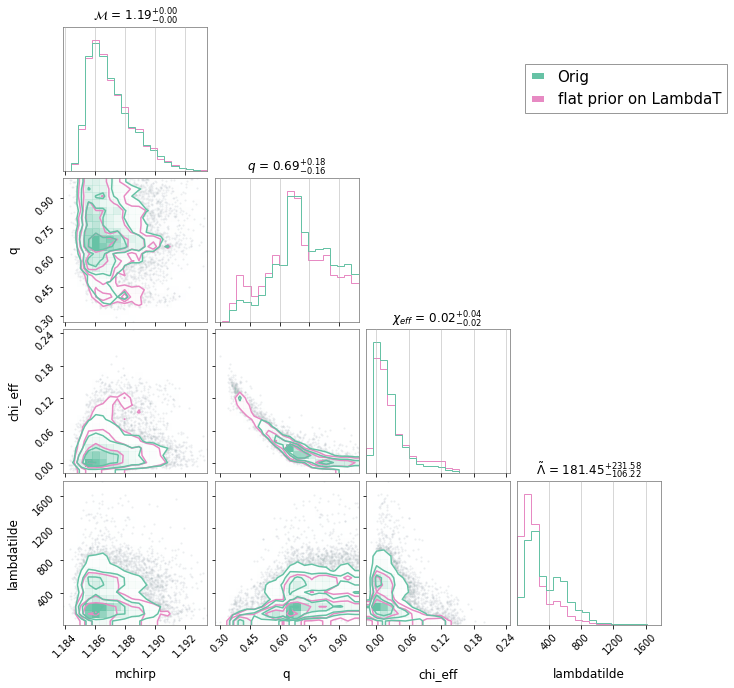

In [ ]:
#Corner Plot of lambdatweight flat Prior to mchirp, q, chi_eff, lambdatilde

figure = corner.corner(data,weights = data["lambdatweight"], color = cmap(2),var_names = ["mchirp","q",'chi_eff',"lambdatilde"], 
                       labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$"),
                       show_titles=True)
corner.corner(data,color = cmap(0),fig=figure, var_names = ["mchirp","q",'chi_eff',"lambdatilde"])

l1 = mlines.Line2D([], [], color=cmap(0), label='Orig')
l2 = mlines.Line2D([], [], color=cmap(2), label='flat prior on LambdaT')
plt.legend(handles=[l1,l2],bbox_to_anchor=(0, 3.5,1,2), loc='lower left',fontsize= 15)
plt.show()


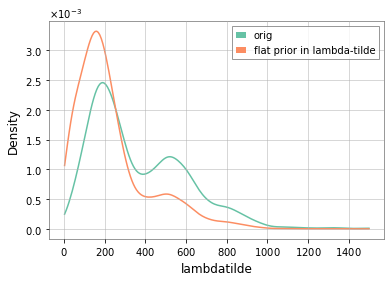

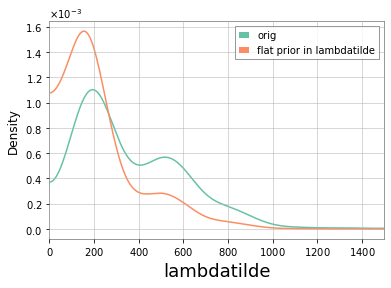

In [45]:
#1-D KDE plot of Lmabdatilde of using a flat prior on lambdatilde

sns.kdeplot(data=data, x='lambdatilde',  color=cmap(0), label='orig',cut=0, clip=(0,1500))
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(1), label='flat prior in lambda-tilde',
            weights = data['lambdatweight'],cut=0, clip=(0,1500))
plt.legend()
plt.show()

# New plot that considers the hard boundaries

data_reflect = reflect(data['lambdatilde'], 0)
trueKDE = list(data_reflect) + list(data['lambdatilde'])
# print(data['lambdatilde'])
trueKDE_LambdaT_weights = list(data['lambdatweight']) + list(data['lambdatweight']) #list format? List or Array, Floats or int? 'wide-form data' match to the same list as bellcurve. compare lists of of massweights and lambdaT. 
# print(data['lambdatweight'])

sns.kdeplot(x=trueKDE,  color=cmap(0), label='orig',cut=0, clip=(0,1500))

sns.kdeplot(x=trueKDE,  color=cmap(1), label='flat prior in lambdatilde',
            weights = trueKDE_LambdaT_weights,cut=0, clip=(0,1500))

plt.xlabel('lambdatilde', fontsize=18)
plt.xlim(0,1500)
plt.legend()
plt.show()


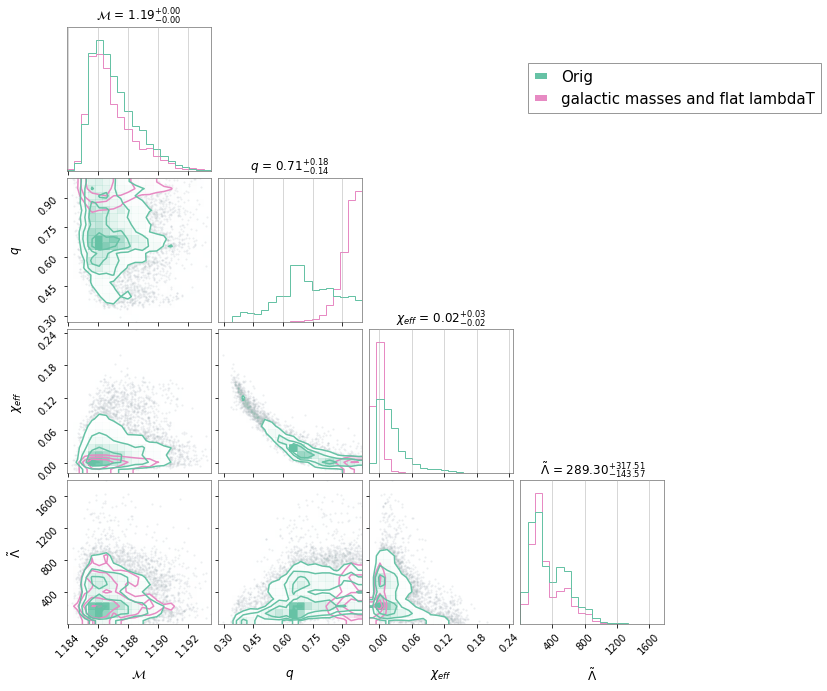

In [ ]:
#Corner Plot of galatic mass prior and lambdatweight flat Prior to mchirp, q, chi_eff, lambdatilde

figure = corner.corner(data,weights = data["lambdatweight"]*data["massweight"], color = cmap(2),var_names = ["mchirp","q",'chi_eff',"lambdatilde"])
corner.corner(data,color = cmap(0),fig=figure, var_names = ["mchirp","q",'chi_eff',"lambdatilde"],labels = (r"$\mathcal{M}$",r"$q$",r"$\chi_{eff}$",r"$\tilde\Lambda$"),
                       show_titles=True)

l1 = mlines.Line2D([], [], color=cmap(0), label='Orig')
l2 = mlines.Line2D([], [], color=cmap(2), label='galactic masses and flat lambdaT')
plt.legend(handles=[l1,l2],bbox_to_anchor=(0, 3.5,1,2), loc='lower left',fontsize= 15)
plt.show()

plt.show()

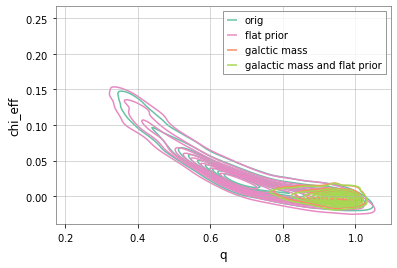

In [ ]:
#Q vs Chi_Eff KDS Plot using Galatic reweights and lambdatweight flat prior

sns.kdeplot(data=data, x='q', y='chi_eff',  color=cmap(0), label='orig')
sns.kdeplot(data=data, x='q', y='chi_eff', color=cmap(2), label='flat prior',
            weights = data['lambdatweight'])
sns.kdeplot(data=data, x='q', y='chi_eff',  color=cmap(1), label='galctic mass',
            weights = data['massweight'])

sns.kdeplot(data=data, x='q', y='chi_eff',color=cmap(3), label='galactic mass and flat prior',
            weights = data['massweight']*data['lambdatweight'])
plt.legend()
plt.show()

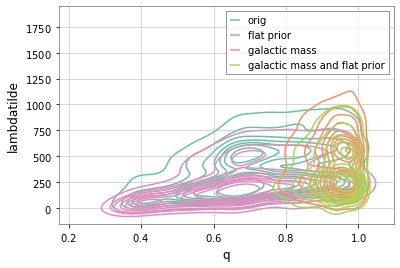

In [48]:
#lambdatilde vs chi_Eff KDS Plot using Galatic reweights and lambdatweight flat prior


sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(0), label='orig')
sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(2), label='flat prior',
            weights = data['lambdatweight'])
sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(1), label='galactic mass ',
            weights = data['massweight'])
sns.kdeplot(data=data, x='q', y='lambdatilde',  color=cmap(3), label='galactic mass and flat prior',
            weights = data['massweight']*data['lambdatweight'])
plt.legend()
# plt.xlim(0,1500) 
plt.show()

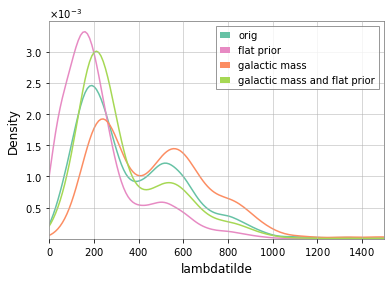

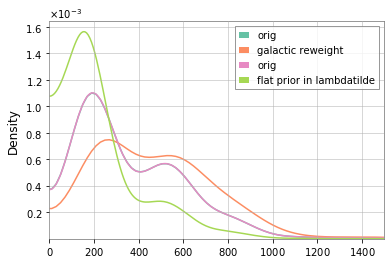

In [44]:
#1-D KDE plot of Galatic reweights and lambdatweight flat prior on lambdatilde

# Originial plots before considering the hard boundaries
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(0), label='orig')
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(2), label='flat prior',
            weights = data['lambdatweight'])
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(1), label='galactic mass ',
            weights = data['massweight'])
sns.kdeplot(data=data, x='lambdatilde',  color=cmap(3), label='galactic mass and flat prior',
            weights = data['massweight']*data['lambdatweight'])
plt.legend()
plt.xlim(0,1500)
plt.show()

# New plot that considers the hard boundaries

data_reflect = reflect(data['lambdatilde'], 0)
trueKDE = list(data_reflect) + list(data['lambdatilde'])
trueKDE_weights = list(data['massweight']) + list(data['massweight']) 
trueKDE_LambdaT_weights = list(data['lambdatweight']) + list(data['lambdatweight'])


##In this section I changed the weights 
sns.kdeplot(x = trueKDE,  color=cmap(0), label='orig') 
# plt.hist(data['lambdatilde'], density = True, histtype = 'step', bins = 100) #If you want to view as a hist

sns.kdeplot(x = trueKDE,  color=cmap(1), label='galactic reweight',
            weights = trueKDE_weights) #Adding Massweights
sns.kdeplot(x=trueKDE,  color=cmap(2), label='orig',cut=0, clip=(0,1500))
sns.kdeplot(x=trueKDE,  color=cmap(3), label='flat prior in lambdatilde',
            weights = trueKDE_LambdaT_weights,cut=0, clip=(0,1500)) 


plt.xlim(0,1500)
plt.legend()
plt.show()


